In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from  datetime import datetime, timedelta
import tqdm
import networkx as nx
import us_states
import random

In [66]:
states_neighbors = {}
for k,v in us_states.STATES_CONNECTIVITY.items():
    states_neighbors[us_states.STATE_TO_ABBR[k]] = [us_states.STATE_TO_ABBR[s] for s in v]
states_neighbors

{'AL': ['MS', 'TN', 'FL', 'GA'],
 'AK': [],
 'AZ': ['NV', 'NM', 'UT', 'CA', 'CO'],
 'AR': ['OK', 'TN', 'TX', 'LA', 'MS', 'MO'],
 'CA': ['OR', 'AZ', 'NV'],
 'CO': ['NM', 'OK', 'UT', 'WY', 'AZ', 'KS', 'NE'],
 'CT': ['NY', 'RI', 'MA'],
 'DE': ['NJ', 'PA', 'MD'],
 'DC': ['MD', 'VA'],
 'FL': ['GA', 'AL'],
 'GA': ['NC', 'SC', 'TN', 'AL', 'FL'],
 'HI': [],
 'ID': ['UT', 'WA', 'WY', 'MT', 'NV', 'OR'],
 'IL': ['KY', 'MO', 'WI', 'IN', 'IA', 'MI'],
 'IN': ['MI', 'OH', 'IL', 'KY'],
 'IA': ['NE', 'SD', 'WI', 'IL', 'MN', 'MO'],
 'KS': ['NE', 'OK', 'CO', 'MO'],
 'KY': ['TN', 'VA', 'WV', 'IL', 'IN', 'MO', 'OH'],
 'LA': ['TX', 'AR', 'MS'],
 'ME': ['NH'],
 'MD': ['VA', 'WV', 'DE', 'PA'],
 'MA': ['NY', 'RI', 'VT', 'CT', 'NH'],
 'MI': ['OH', 'WI', 'IL', 'IN', 'MN'],
 'MN': ['ND', 'SD', 'WI', 'IA', 'MI'],
 'MS': ['LA', 'TN', 'AL', 'AR'],
 'MO': ['NE', 'OK', 'TN', 'AR', 'IL', 'IA', 'KS', 'KY'],
 'MT': ['SD', 'WY', 'ID', 'ND'],
 'NE': ['MO', 'SD', 'WY', 'CO', 'IA', 'KS'],
 'NV': ['ID', 'OR', 'UT', 'AZ', 'CA'

In [67]:
X = pd.read_excel('SSDB_Raw_Data.xlsx', 'INCIDENT')
# X['year'] = X['Date'].apply(lambda d: int(d[:4]))
X['Date'] = X['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
X = X[X['Date'] >= datetime(year=2010,month=1,day=1)]
X.reset_index(drop=True, inplace=True)
X

,Incident_ID,Sources,Number_News,Media_Attention,Reliability,Date,Quarter,School,City,State,...,Accomplice,Hostages,Barricade,Officer_Involved,Bullied,Domestic_Violence,Gang_Related,Preplanned,Shots_Fired,Active_Shooter_FBI
0,20200727AZCAO,https://www.kgun9.com/news/education/man-dies-...,3,Local,4,2020-07-27,Summer,Canyon del Oro High School,Oro Valley,AZ,...,No,No,No,No,No,No,No,No,NaN,No
1,20200721SCBRO,https://abcnews4.com/news/crime-news/person-of...,2,Local,3,2020-07-21,Summer,Brookdale Elementary School,Orangeburg,SC,...,No,No,No,No,No,No,NaN,No,NaN,No
2,20200714MIWID,https://www.detroitnews.com/story/news/local/m...,1,Local,3,2020-07-14,Summer,Willow Woods Elementary School,Detroit,MI,...,No,No,No,No,No,No,No,No,NaN,No
3,20200704INLAM,https://www.abc57.com/news/murder-suspect-char...,2,Local,4,2020-07-04,Summer,Lake Hills Elementary School,Michigan City,IN,...,No,No,No,No,No,No,No,No,NaN,No
4,20200701ILFRP,https://www.dailyherald.com/news/20200714/pros...,1,Local,3,2020-07-01,Summer,Frost Elementary School,Prospect Heights,IL,...,Yes,No,No,No,No,No,Yes,No,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,20220605INWEG,https://abc7chicago.com/gary-indiana-shooting-...,2,Local,4,2022-06-05,Summer,West Side Leadership Academy,Gary,IN,...,NaN,No,No,No,No,No,NaN,No,99,No
1030,20220607MIPED,https://www.wxyz.com/news/shots-fired-at-persh...,4,Local,4,2022-06-07,Summer,Pershing High School,Detroit,MI,...,NaN,No,No,No,No,No,NaN,No,99,No
1031,20220608ARLIL,https://www.kark.com/crime/lrpd-school-bus-hit...,5,National,4,2022-06-08,Summer,Little Rock School District Bus,Little Rock,AR,...,NaN,No,No,No,No,No,NaN,No,99,No
1032,20220609ALWAG,https://www.live5news.com/2022/06/09/potential...,100,National,4,2022-06-09,Summer,Walnut Park Elementary School,Gadsden,AL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [68]:
events = X[["Date", "State"]]
events

,Date,State
0,2020-07-27,AZ
1,2020-07-21,SC
2,2020-07-14,MI
3,2020-07-04,IN
4,2020-07-01,IL
...,...,...
1029,2022-06-05,IN
1030,2022-06-07,MI
1031,2022-06-08,AR
1032,2022-06-09,AL


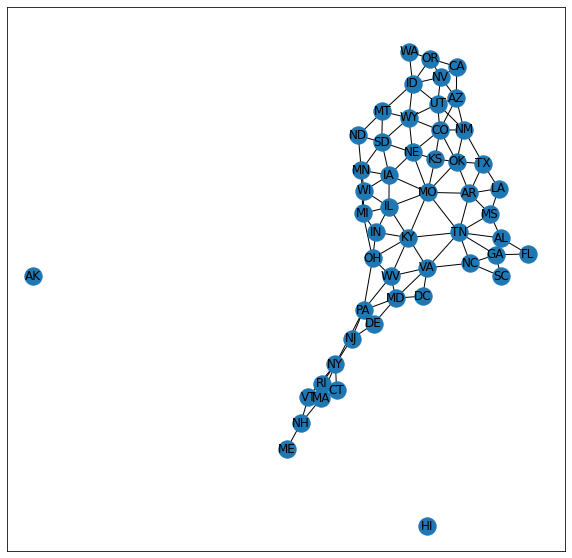

In [69]:
G = nx.Graph()
for s in events['State'].unique():
    G.add_node(s)
    for n in states_neighbors[s]:
        G.add_edge(s,n)

plt.figure(figsize=(10,10))
nx.draw_networkx(G)

In [70]:
nx.shortest_path_length(G, "MS", "NY")

5

In [75]:
S = list(G.nodes())
def get_random_state(source_state):
    s = random.choice(S)
    try:
        s_path_length = nx.shortest_path_length(G, s, source_state)
        while s_path_length <= 2:
            s = random.choice(S)
            s_path_length = nx.shortest_path_length(G, s, source_state)
        return s
    except nx.NetworkXNoPath:
        return s

get_random_state("NY")

'MO'

In [78]:
DAY = timedelta(days=1)
WEEK = timedelta(weeks=1) 

ates = []
for i in range(100):
    x = []
    for i, row in events.iterrows():
        ### State with shooting
        s,d = row['State'], row['Date']
        neighbors = states_neighbors[s]
        next_week_shooting = events[events['Date'] > d][events['Date'] <= d + WEEK]
        next_week_shooting_states = next_week_shooting['State'].tolist()
        num_neighbors_shootings_1 = sum([1*(_s in neighbors) + 1*(_s==s) for _s in next_week_shooting_states]) / (len(neighbors) + 1)

        ### State without shooting
        rand_state = get_random_state(s)
        while((events["Date"]==d) & (events["State"] == rand_state)).sum():
            rand_state = get_random_state(s)
        neighbors = states_neighbors[rand_state]
        next_week_shooting = events[events['Date'] > d][events['Date'] <= d + WEEK]
        next_week_shooting_states = next_week_shooting['State'].tolist()
        num_neighbors_shootings_0 = sum([1*(_s in neighbors) + 1*(_s==rand_state) for _s in next_week_shooting_states]) / (len(neighbors) + 1)
        
        x.append((d, s, rand_state, num_neighbors_shootings_1, num_neighbors_shootings_0))
    ates.append(np.mean([row[3]-row[4] for row in x]))
ates

/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_4032/3066339704.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  next_week_shooting = events[events['Date'] > d][events['Date'] <= d + WEEK]
/var/folders/wd/57_v9c5142x7mhyp18nb4bt80000gn/T/ipykernel_4032/3066339704.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  next_week_shooting = events[events['Date'] > d][events['Date'] <= d + WEEK]


[0.02616514690982776,
 0.029468315372570695,
 0.024292315249762057,
 0.02297404132510516,
 0.02974616990574437,
 0.03262372969819778,
 0.02701252648061159,
 0.026985662092045073,
 0.02520570446102361,
 0.02618663842068097,
 0.026953808602744767,
 0.03460517024346812,
 0.02328374934757913,
 0.02741242209327316,
 0.030747060268336863,
 0.026092229283718647,
 0.028478170765404806,
 0.022969819778330413,
 0.02993652328758712,
 0.027281170366276745,
 0.029605323754259928,
 0.030121120014737032,
 0.03811442694421418,
 0.02865854594577999,
 0.02080723649872586,
 0.02958997267507906,
 0.031329249946271225,
 0.028888428356513462,
 0.017135642135642136,
 0.025431365324982344,
 0.02497965982008535,
 0.031607488256424426,
 0.026401937306192627,
 0.01717171717171717,
 0.02760239169813638,
 0.023466427189831444,
 0.03187881858094624,
 0.023778054097203034,
 0.035947622117834886,
 0.031645865954376594,
 0.03164317951551994,
 0.024349498019710782,
 0.02478508489146787,
 0.030150670842160204,
 0.024025

In [79]:
def get_ci(v):
    mid = np.mean(v)
    se = np.std(v) / np.sqrt(len(v))
    return (mid - 1.96*se, mid + 1.96*se)

print("MEAN ATE", np.mean(ates))
print("ATE CI", get_ci(ates))

MEAN ATE 0.02758894031500414
ATE CI (0.026772869702657236, 0.028405010927351045)


In [63]:
x

[(Timestamp('2020-07-27 00:00:00'), 'AZ', 'VT', 0.0, 0.0),
 (Timestamp('2020-07-21 00:00:00'), 'SC', 'VT', 0.0, 0.0),
 (Timestamp('2020-07-14 00:00:00'), 'MI', 'TX', 0.0, 0.0),
 (Timestamp('2020-07-04 00:00:00'), 'IN', 'DE', 0.0, 0.0),
 (Timestamp('2020-07-01 00:00:00'), 'IL', 'ND', 0.14285714285714285, 0.0),
 (Timestamp('2020-06-27 00:00:00'), 'VA', 'OK', 0.0, 0.0),
 (Timestamp('2020-06-21 00:00:00'), 'IN', 'NE', 0.0, 0.0),
 (Timestamp('2020-06-18 00:00:00'), 'IN', 'CO', 0.0, 0.0),
 (Timestamp('2020-06-16 00:00:00'), 'FL', 'WV', 0.0, 0.0),
 (Timestamp('2020-06-03 00:00:00'), 'IA', 'NC', 0.0, 0.0),
 (Timestamp('2020-05-27 00:00:00'), 'OH', 'MA', 0.0, 0.0),
 (Timestamp('2020-05-25 00:00:00'), 'AL', 'KS', 0.0, 0.0),
 (Timestamp('2020-05-22 00:00:00'), 'OH', 'CT', 0.0, 0.0),
 (Timestamp('2020-05-19 00:00:00'), 'VA', 'MI', 0.0, 0.16666666666666666),
 (Timestamp('2020-05-15 00:00:00'), 'NC', 'RI', 0.2, 0.0),
 (Timestamp('2020-05-05 00:00:00'), 'CA', 'NY', 0.0, 0.0),
 (Timestamp('2020-04-13 

0.006136593902551349